In [1]:
#import scrublet as scr
import numpy as np
import pandas as pd
import statistics as st
import re
import csv
import scanpy as sc 
import scanpy.external as sce
import phate
import matplotlib
from matplotlib import pyplot as plt
import warnings
import scipy
from scipy.stats import binom
from scipy.stats import multinomial
import seaborn as sns
from numpy.polynomial.polynomial import polyfit
from scipy.stats import hypergeom
import warnings
warnings.filterwarnings('ignore')
import scrublet as scr
import harmonypy as hm
import pickle
from random import sample
from matplotlib_venn import venn2

### Load Data

In [2]:
CM_Cells = sc.read_h5ad('h5ad')

In [4]:
CM_Cells

AnnData object with n_obs × n_vars = 4717 × 29230
    obs: 'T_Reps', 'B_Reps', 'Sample', 'n_counts_all', 'louvain', 'dpt_pseudotime', 'rank_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mean', 'std'
    uns: 'Sample_colors', 'broad_clusters', 'diffmap_evals', 'iroot', 'louvain', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'rank_genes_r1.0', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_phate', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

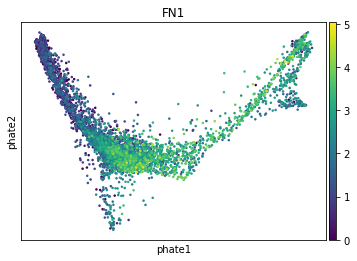

In [5]:
sce.pl.phate(CM_Cells, color='FN1')

### Cluster Defining Gene CSV

In [8]:
cluster_id = ['Mid_CM', 'Late_CM', 'Early_CM']
cluster_dict = dict(zip(CM_Cells.obs.louvain.cat.categories, cluster_id))

In [9]:
Cluster = '0'
Pos_Genes = CM_Cells.uns['rank_genes_groups']['names'][Cluster][CM_Cells.uns['rank_genes_groups']['scores'][Cluster] > 0]
Pval_Genes = CM_Cells.uns['rank_genes_groups']['names'][Cluster][CM_Cells.uns['rank_genes_groups']['pvals_adj'][Cluster] < 0.05]

Pvals = []
for gene in Pos_Genes[0:100]:
    pval_pos = np.argwhere(CM_Cells.uns['rank_genes_groups']['names'][Cluster] == gene)[0][0]
    if CM_Cells.uns['rank_genes_groups']['pvals'][Cluster][pval_pos] == 0:
        Pvals.append(2.225e-308)
    else:
        Pvals.append(CM_Cells.uns['rank_genes_groups']['pvals'][Cluster][pval_pos])

Cluster_Gene_DF = pd.DataFrame(data=Pos_Genes[0:100], columns=[cluster_dict[str(Cluster)] + '_genes'])
Cluster_Gene_DF[cluster_dict[str(Cluster)] + '_pvals']  = Pvals

In [10]:
for cluster in CM_Cells.obs.louvain.cat.categories:
    if cluster == 0:
        continue
    
    Pos_Genes = CM_Cells.uns['rank_genes_groups']['names'][cluster][CM_Cells.uns['rank_genes_groups']['scores'][Cluster] > 0]
    Pval_Genes = CM_Cells.uns['rank_genes_groups']['names'][cluster][CM_Cells.uns['rank_genes_groups']['pvals_adj'][Cluster] < 0.05]
    Sig_Genes = [i for i in Pval_Genes if i in Pos_Genes]
    
    Pvals = []
    for gene in Pos_Genes[0:100]:
        pval_pos = np.argwhere(CM_Cells.uns['rank_genes_groups']['names'][cluster] == gene)[0][0]
        if CM_Cells.uns['rank_genes_groups']['pvals'][cluster][pval_pos] == 0:
            Pvals.append(2.225e-308)
        else:
            Pvals.append(CM_Cells.uns['rank_genes_groups']['pvals'][cluster][pval_pos])
    Cluster_Gene_DF[cluster_dict[str(cluster)] + '_genes'] = Pos_Genes[0:100]
    Cluster_Gene_DF[cluster_dict[str(cluster)] + '_pvals'] = Pvals

In [11]:
Cluster_Gene_DF.to_csv('KO_Updated_CM_ClusterGenes.csv')

### Plot PHATE

In [4]:
query_region = '0'
Cluster_0 = []
for bc in CM_Cells.obs.index:
    if CM_Cells.obs.louvain[bc] == query_region:
        Cluster_0.append(1)
    else:
        Cluster_0.append(0)

In [5]:
query_region = '1'
Cluster_1 = []
for bc in CM_Cells.obs.index:
    if CM_Cells.obs.louvain[bc] == query_region:
        Cluster_1.append(1)
    else:
        Cluster_1.append(0)

In [6]:
query_region = '2'
Cluster_2 = []
for bc in CM_Cells.obs.index:
    if CM_Cells.obs.louvain[bc] == query_region:
        Cluster_2.append(1)
    else:
        Cluster_2.append(0)

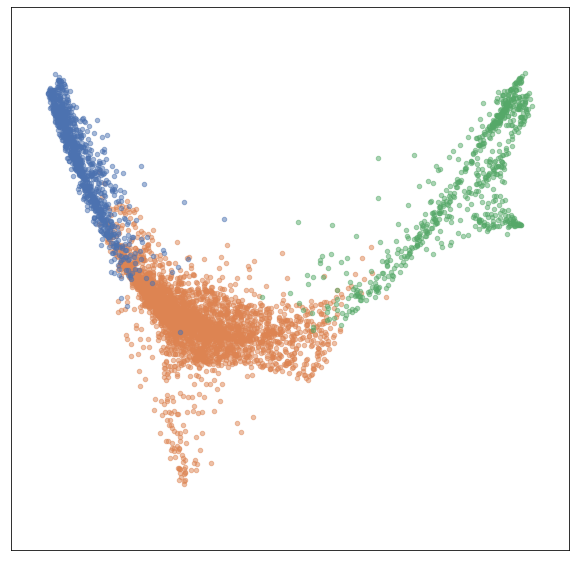

In [9]:
fig, ax = plt.subplots(figsize=(10,10))

indices = np.nonzero(Cluster_0)[0]
x = CM_Cells.obsm['X_phate'][indices,0]
y = CM_Cells.obsm['X_phate'][indices,1]
ax.scatter(x,
           y, 
           c='#dd8452',
           s=20,
        alpha=0.5)

indices = np.nonzero(Cluster_1)[0]
x = CM_Cells.obsm['X_phate'][indices,0]
y = CM_Cells.obsm['X_phate'][indices,1]
ax.scatter(x, 
           y, 
           c='#4c72b0',
           s=20,
        alpha=0.5)

indices = np.nonzero(Cluster_2)[0]
x = CM_Cells.obsm['X_phate'][indices,0]
y = CM_Cells.obsm['X_phate'][indices,1]
ax.scatter(x, 
           y, 
           c='#55a868',
           s=20,
        alpha=0.5)
                     
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticks([])

lim_adj = 5
ylim_min = CM_Cells.obsm['X_phate'][:,1].min() - lim_adj
ylim_max = CM_Cells.obsm['X_phate'][:,1].max() + lim_adj
xlim_min = CM_Cells.obsm['X_phate'][:,0].min() - lim_adj
xlim_max = CM_Cells.obsm['X_phate'][:,0].max() + lim_adj



ax.set_xlim(xlim_min, xlim_max)
ax.set_ylim(ylim_min, ylim_max)


ax.grid(False)

plt.savefig('png', dpi =600)

### Plot PHATE Pseudo

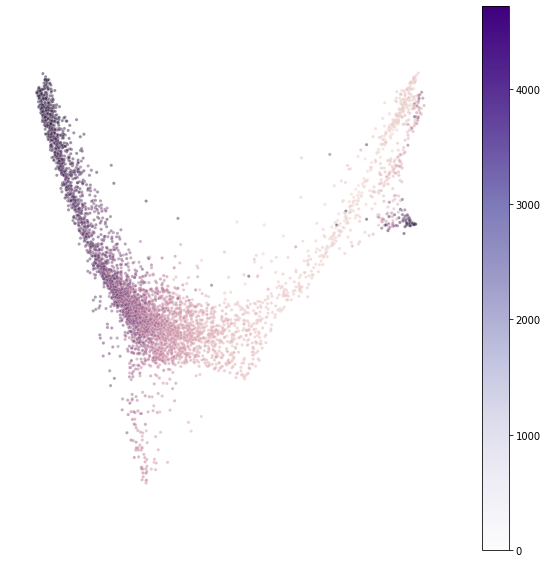

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x = CM_Cells.obsm['X_phate'][:,0], y = CM_Cells.obsm['X_phate'][:,1], hue = CM_Cells.obs.rank_pseudotime, s=10, alpha=0.5)

norm = plt.Normalize(CM_Cells.obs.rank_pseudotime.min(), CM_Cells.obs.rank_pseudotime.max())
sm = plt.cm.ScalarMappable(cmap='Purples', norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

lim_adj = 5
ylim_min = CM_Cells.obsm['X_phate'][:,1].min() - lim_adj
ylim_max = CM_Cells.obsm['X_phate'][:,1].max() + lim_adj
xlim_min = CM_Cells.obsm['X_phate'][:,0].min() - lim_adj
xlim_max = CM_Cells.obsm['X_phate'][:,0].max() + lim_adj



ax.set_xlim(xlim_min, xlim_max)
ax.set_ylim(ylim_min, ylim_max)


plt.axis('off')
ax.grid(False)
fig.savefig('png', dpi= 600)

### Plot PHATE Genes

In [20]:
%%capture
Target  = 'FN1'
Target_Expression = []
[Target_Expression.append(i[0]) for i in CM_Cells.raw.X[:,np.argwhere(CM_Cells.raw.var_names == Target)[0][0]].todense().tolist()]
CM_Cells.obs['Target'] = Target_Expression/np.log(2)

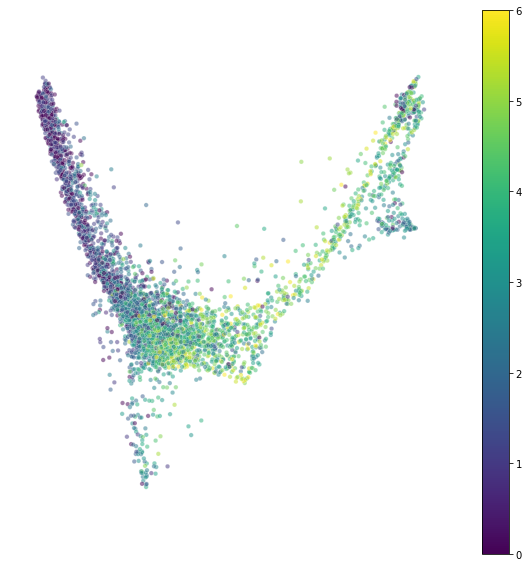

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
Max_Exp = 6
sns.scatterplot(x = CM_Cells.obsm['X_phate'][:,0], y = CM_Cells.obsm['X_phate'][:,1], hue = CM_Cells.obs.Target, s=20, alpha=0.5, palette='viridis', hue_norm=(0, Max_Exp))
norm = plt.Normalize(CM_Cells.obs.Target.min(), Max_Exp)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])


# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

lim_adj = 5
ylim_min = CM_Cells.obsm['X_phate'][:,1].min() - lim_adj
ylim_max = CM_Cells.obsm['X_phate'][:,1].max() + lim_adj
xlim_min = CM_Cells.obsm['X_phate'][:,0].min() - lim_adj
xlim_max = CM_Cells.obsm['X_phate'][:,0].max() + lim_adj



ax.set_xlim(xlim_min, xlim_max)
ax.set_ylim(ylim_min, ylim_max)




plt.axis('off')
ax.grid(False)
fig.savefig('' + Target + '.png', dpi =600)